In [1]:
%cd C:\TensorFlow\models\research\object_detection

import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline

C:\TensorFlow\models\research\object_detection
INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [5]:
labelmap_path = 'C:/TensorFlow/workspace/face_mask_detection/annotations/labelmap.pbtxt'

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

In [7]:
output_directory = 'C:/TensorFlow/workspace/face_mask_detection/exported-models/inference_graph'

In [8]:
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'{output_directory}/saved_model')

In [9]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

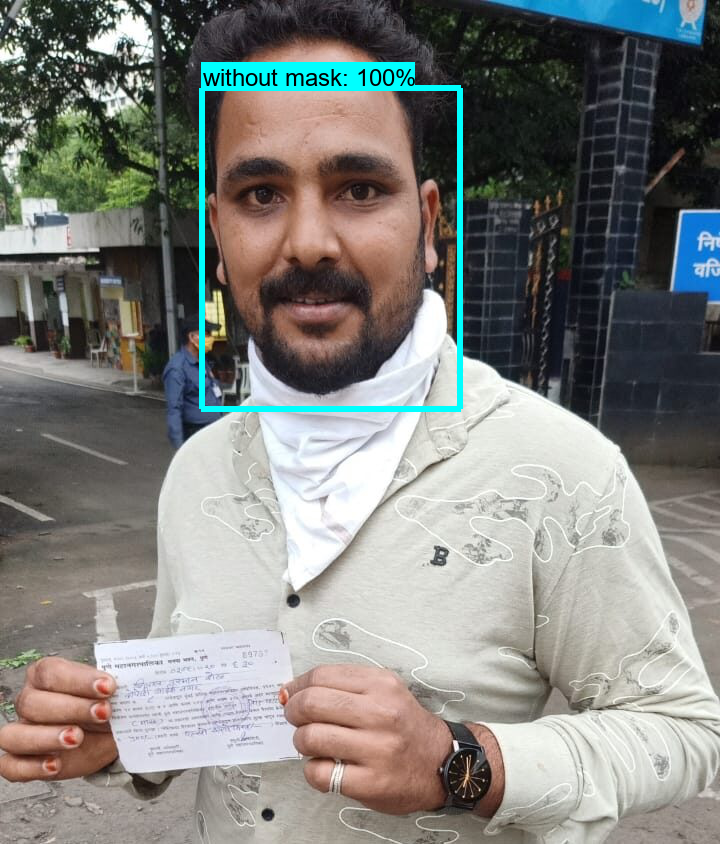

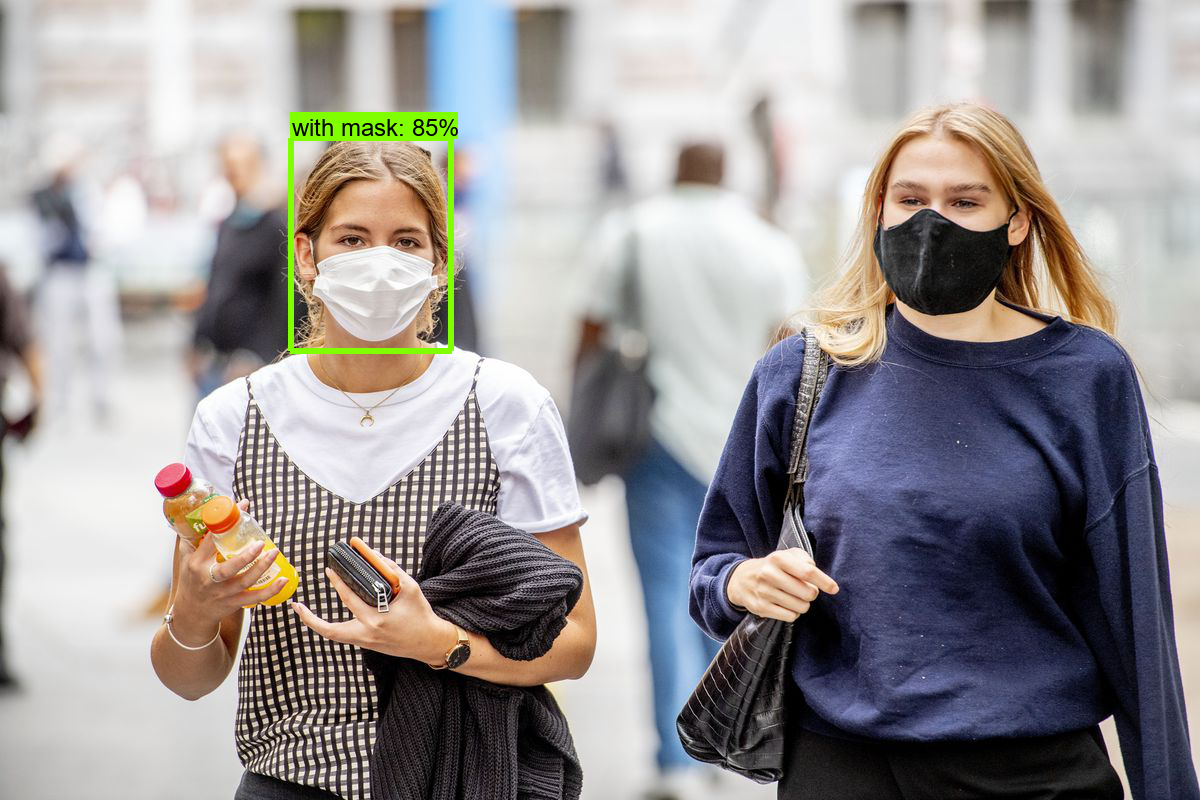

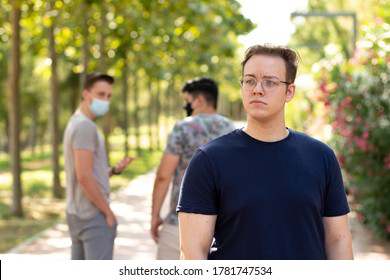

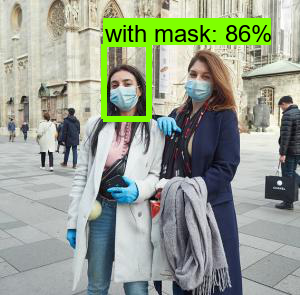

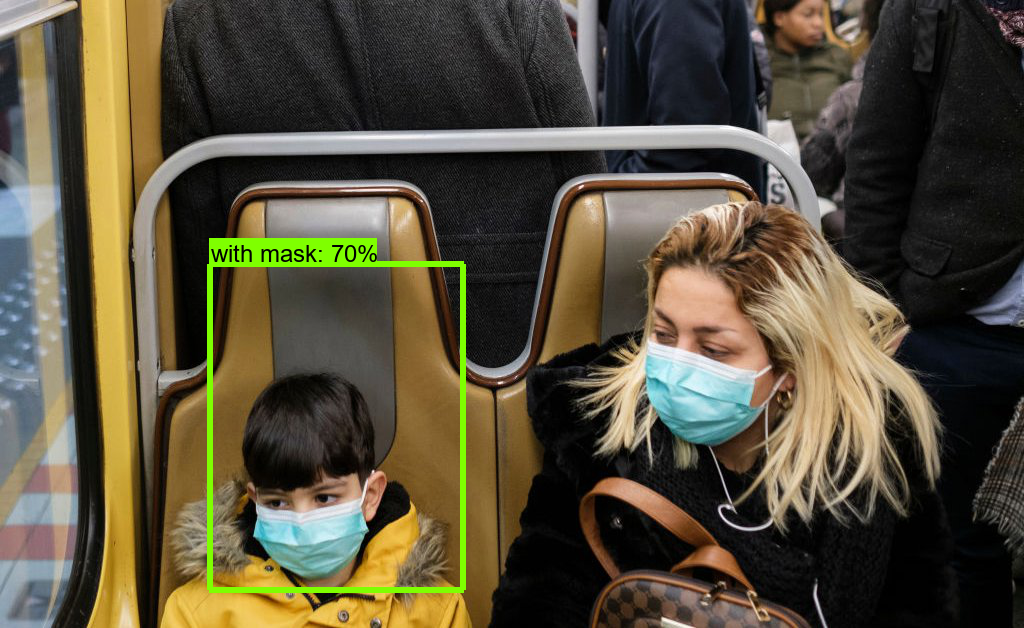

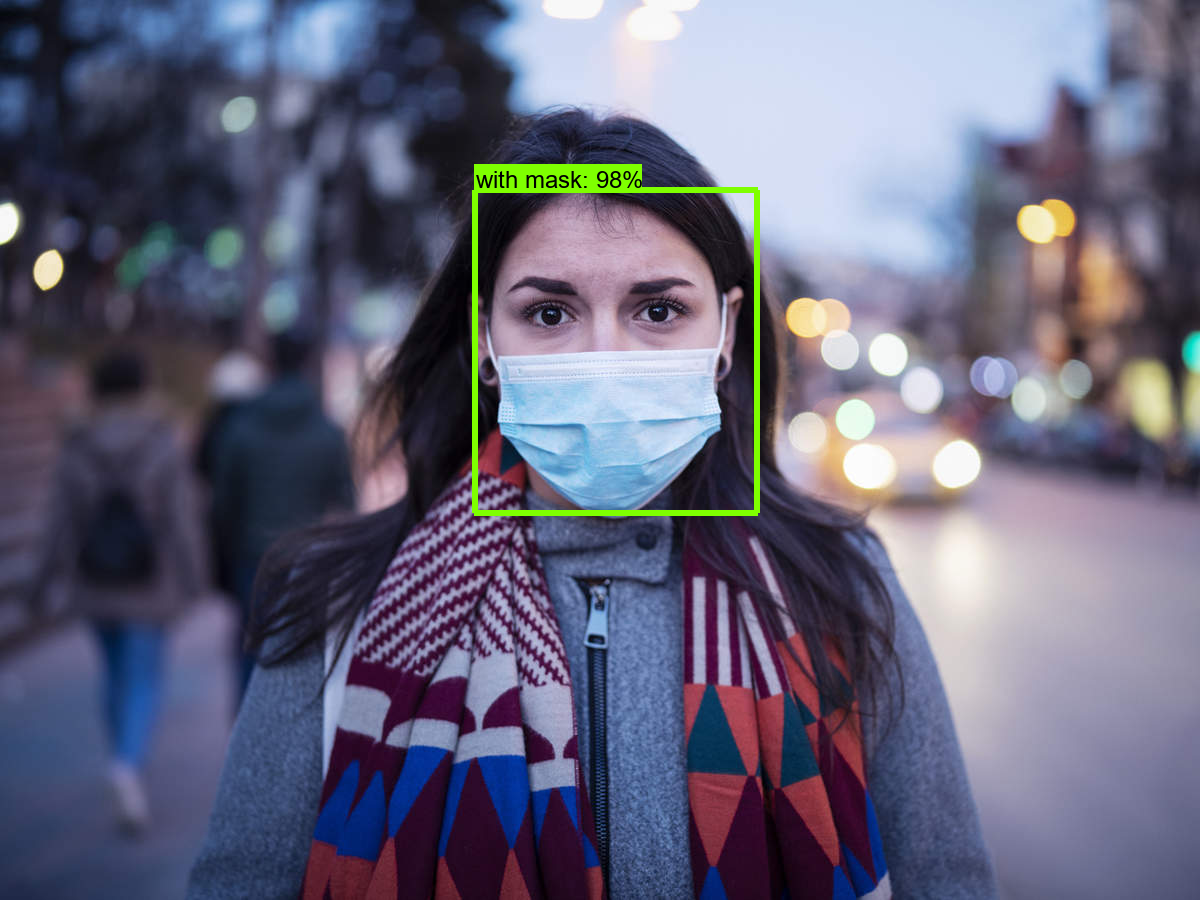

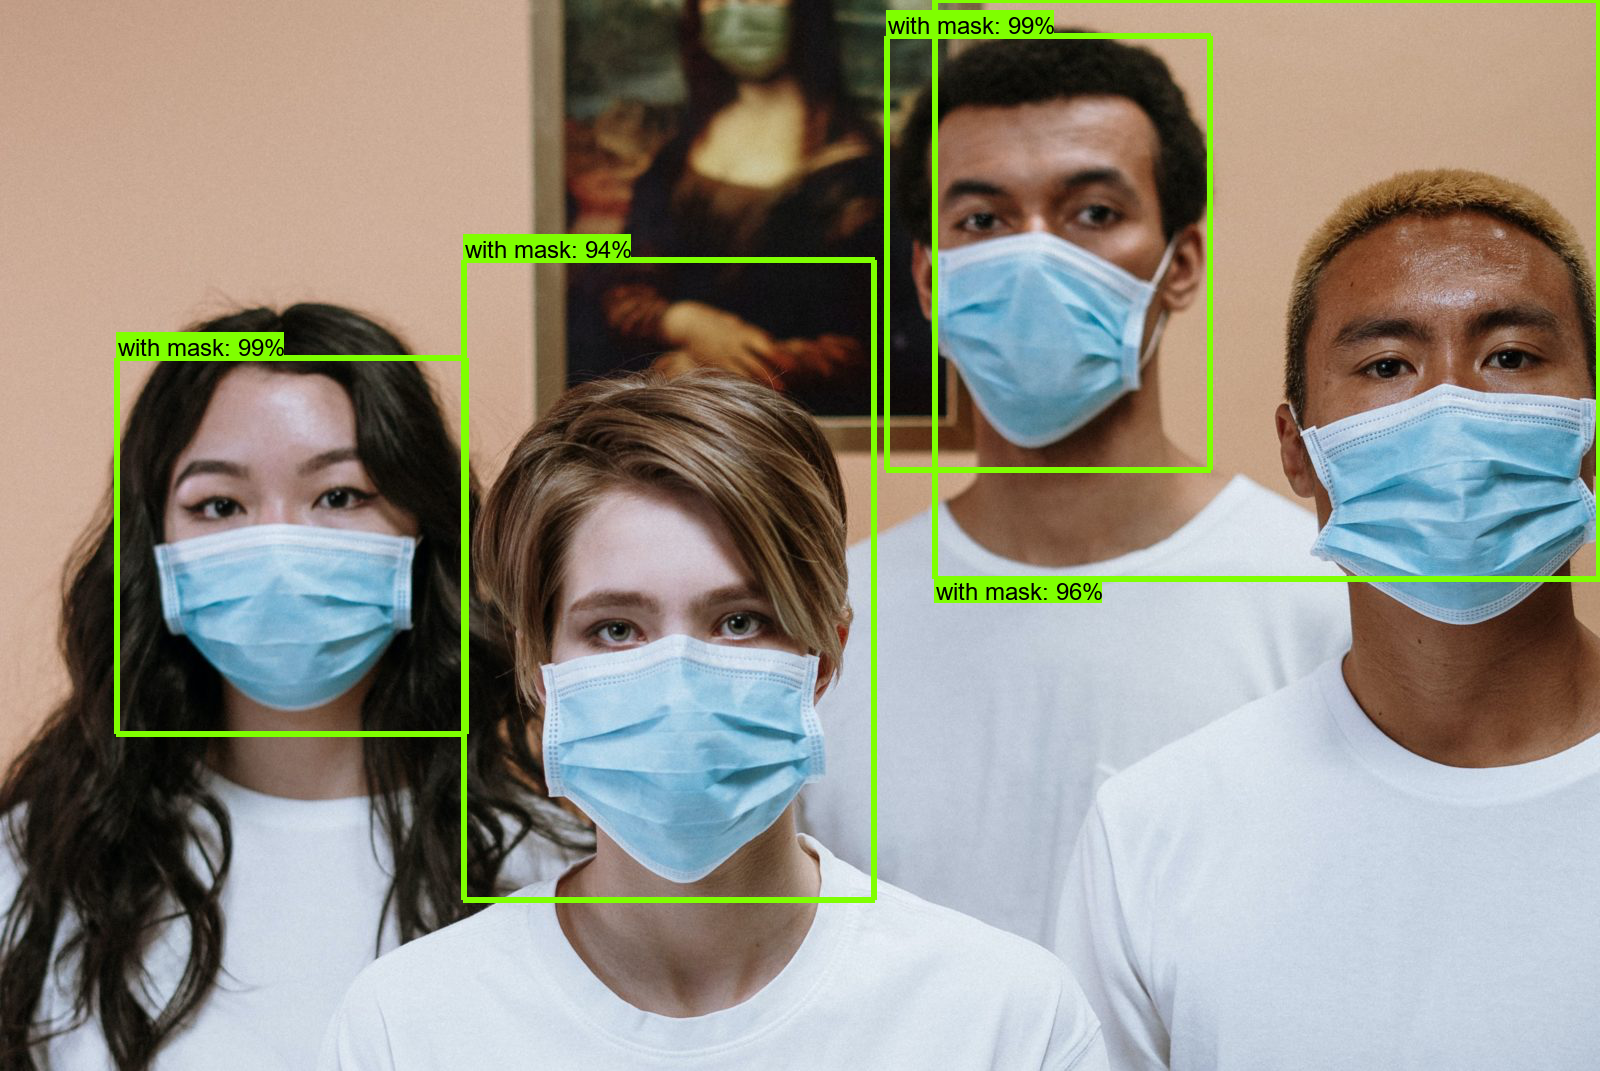

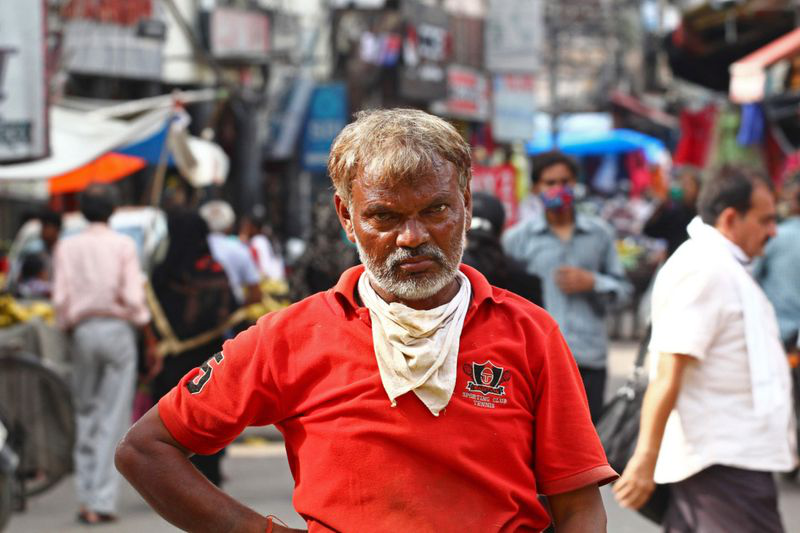

In [29]:
for image_path in glob.glob('C:/TensorFlow/workspace/face_mask_detection/images/detect/*.jpg'):
  image_np = load_image_into_numpy_array(image_path)
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      max_boxes_to_draw=5,
      min_score_thresh=.7,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=6)
  display(Image.fromarray(image_np))

In [26]:
PATH_TO_FROZEN_GRAPH = output_directory + '/saved_model/saved_model.pb'

In [27]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.compat.v1.GraphDef()
  with tf.compat.v2.io.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

DecodeError: Wrong wire type in tag.

In [22]:
import cv2
cap = cv2.VideoCapture(0)
try:
    with detection_graph.as_default():
        with tf.Session() as sess:
                # Get handles to input and output tensors
                ops = tf.get_default_graph().get_operations()
                all_tensor_names = {output.name for op in ops for output in op.outputs}
                tensor_dict = {}
                for key in [
                  'num_detections', 'detection_boxes', 'detection_scores',
                  'detection_classes', 'detection_masks'
                ]:
                    tensor_name = key + ':0'
                    if tensor_name in all_tensor_names:
                        tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)

                while True:
                    ret, image_np = cap.read()
                    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                    image_np_expanded = np.expand_dims(image_np, axis=0)
                    # Actual detection.
                    output_dict = run_inference_for_single_image(image_np, detection_graph)
                    # Visualization of the results of a detection.
                    vis_util.visualize_boxes_and_labels_on_image_array(
                        image_np,
                        output_dict['detection_boxes'],
                        output_dict['detection_classes'],
                        output_dict['detection_scores'],
                        category_index,
                        instance_masks=output_dict.get('detection_masks'),
                        use_normalized_coordinates=True,
                        line_thickness=8)
                    cv2.imshow('object_detection', cv2.resize(image_np, (800, 600)))
                    if cv2.waitKey(25) & 0xFF == ord('q'):
                        cap.release()
                        cv2.destroyAllWindows()
                        break
except Exception as e:
    print(e)
    cap.release()

name 'detection_graph' is not defined
